In [1]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import warnings
warnings.filterwarnings('ignore')

plt.rcParams['font.sans-serif'] = ['SimHei', 'DejaVu Sans']
plt.rcParams['axes.unicode_minus'] = False
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 8)


In [2]:
data_path = Path('/home/strrl/ssd/score_mobile')
years = [2019, 2020, 2021, 2022, 2023, 2024]
files = {
    year: data_path / f'{year}_toxicr_score.parquet' for year in years
}

# load all year data
dfs = {}
for year, file_path in files.items():
    if file_path.exists():
        df = pd.read_parquet(file_path)
        df['year'] = year
        dfs[year] = df

# concat all data
all_data = pd.concat(dfs.values(), ignore_index=True)
print(f"total data: {len(all_data):,} records")
print(f"year distribution: {all_data['year'].value_counts().sort_index()}")


total data: 139,254 records
year distribution: year
2019    13512
2020    19327
2021    14415
2022    18471
2023    22840
2024    50689
Name: count, dtype: int64


In [3]:
score_col = 'score'

# basic statistics
yearly_stats = all_data.groupby('year')[score_col].agg([
    'count', 'mean', 'median', 'std', 'min', 'max',
    lambda x: np.percentile(x, 25),  # Q1
    lambda x: np.percentile(x, 75),  # Q3
]).round(4)

yearly_stats.columns = ['count', 'mean', 'median', 'std', 'min', 'max', 'Q1', 'Q3']
print("basic statistics:")
print(yearly_stats)


basic statistics:
      count    mean  median     std     min     max      Q1      Q3
year                                                               
2019  13512  0.0320  0.0040  0.1034  0.0015  0.9975  0.0026  0.0085
2020  19327  0.0342  0.0039  0.1239  0.0015  0.9977  0.0025  0.0080
2021  14415  0.0279  0.0040  0.1107  0.0015  0.9976  0.0027  0.0078
2022  18471  0.0236  0.0037  0.0924  0.0015  0.9976  0.0025  0.0071
2023  22840  0.0323  0.0038  0.1143  0.0015  0.9977  0.0025  0.0078
2024  50689  0.0285  0.0041  0.1112  0.0014  0.9977  0.0027  0.0077


toxic analysis (score > 0.5):
 year  total  toxic  toxic_ratio(%)  non_toxic  non_toxic_ratio(%)
 2019  13512    147            1.09      13365               98.91
 2020  19327    337            1.74      18990               98.26
 2021  14415    209            1.45      14206               98.55
 2022  18471    164            0.89      18307               99.11
 2023  22840    331            1.45      22509               98.55
 2024  50689    678            1.34      50011               98.66


([<matplotlib.axis.XTick at 0x78ded7921400>,
 [Text(2019, 0, '2019'),
  Text(2020, 0, '2020'),
  Text(2021, 0, '2021'),
  Text(2022, 0, '2022'),
  Text(2023, 0, '2023'),
  Text(2024, 0, '2024')])

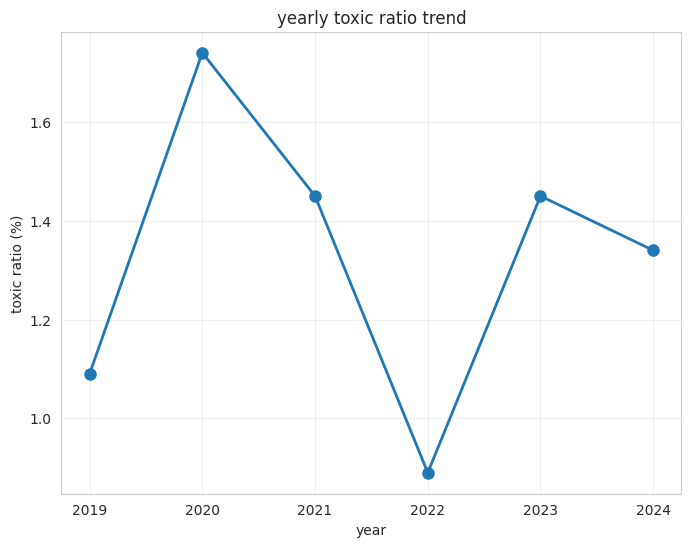

In [4]:
# toxic analysis (score > 0.5)
toxic_threshold = 0.5

# yearly toxic statistics
toxic_stats = []
for year in sorted(dfs.keys()):
    df = dfs[year]
    total_count = len(df)
    toxic_count = len(df[df[score_col] > toxic_threshold])
    toxic_ratio = toxic_count / total_count * 100
    
    toxic_stats.append({
        'year': year,
        'total': total_count,
        'toxic': toxic_count,
        'toxic_ratio(%)': round(toxic_ratio, 2),
        'non_toxic': total_count - toxic_count,
        'non_toxic_ratio(%)': round(100 - toxic_ratio, 2)
    })

toxic_df = pd.DataFrame(toxic_stats)
print("toxic analysis (score > 0.5):")
print(toxic_df.to_string(index=False))

# visualize toxic trend
plt.figure(figsize=(8, 6))
plt.plot(toxic_df['year'], toxic_df['toxic_ratio(%)'], marker='o', linewidth=2, markersize=8)
plt.title('yearly toxic ratio trend')
plt.xlabel('year')
plt.ylabel('toxic ratio (%)')
plt.grid(True, alpha=0.3)
plt.xticks(years)



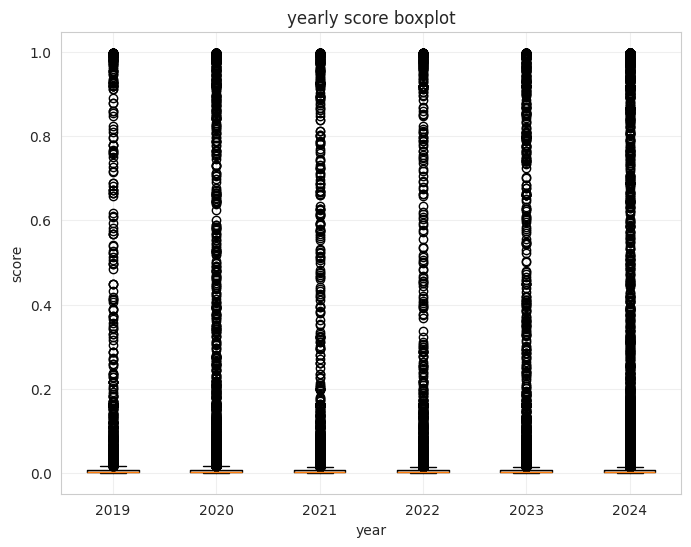

In [5]:
# yearly score distribution comparison
plt.figure(figsize=(8, 6))

# boxplot
yearly_data = [dfs[year][score_col] for year in sorted(dfs.keys())]
plt.boxplot(yearly_data, labels=sorted(dfs.keys()))
plt.title('yearly score boxplot')
plt.xlabel('year')
plt.ylabel('score')
plt.grid(True, alpha=0.3)


yearly interval statistics - count:
year       2019   2020   2021   2022   2023   2024
interval                                          
0.0-0.1   11991  17533  13420  17182  20629  46868
0.1-0.2    1320   1328    726   1066   1791   2946
0.2-0.3      25     57     24     31     32     83
0.3-0.4      16     40     21     13     32     68
0.4-0.5      13     32     15     15     25     46
0.5-0.6      13     29     22     11     15     37
0.6-0.7      13     26     22     12     25     53
0.7-0.8      15     26     20     17     48     43
0.8-0.9      10     51     22     14     43     74
0.9-1.0      96    205    123    110    200    471

yearly interval statistics - ratio(%):
year       2019   2020   2021   2022   2023   2024
interval                                          
0.0-0.1   88.74  90.72  93.10  93.02  90.32  92.46
0.1-0.2    9.77   6.87   5.04   5.77   7.84   5.81
0.2-0.3    0.19   0.29   0.17   0.17   0.14   0.16
0.3-0.4    0.12   0.21   0.15   0.07   0.14   0.13
0.4-0.

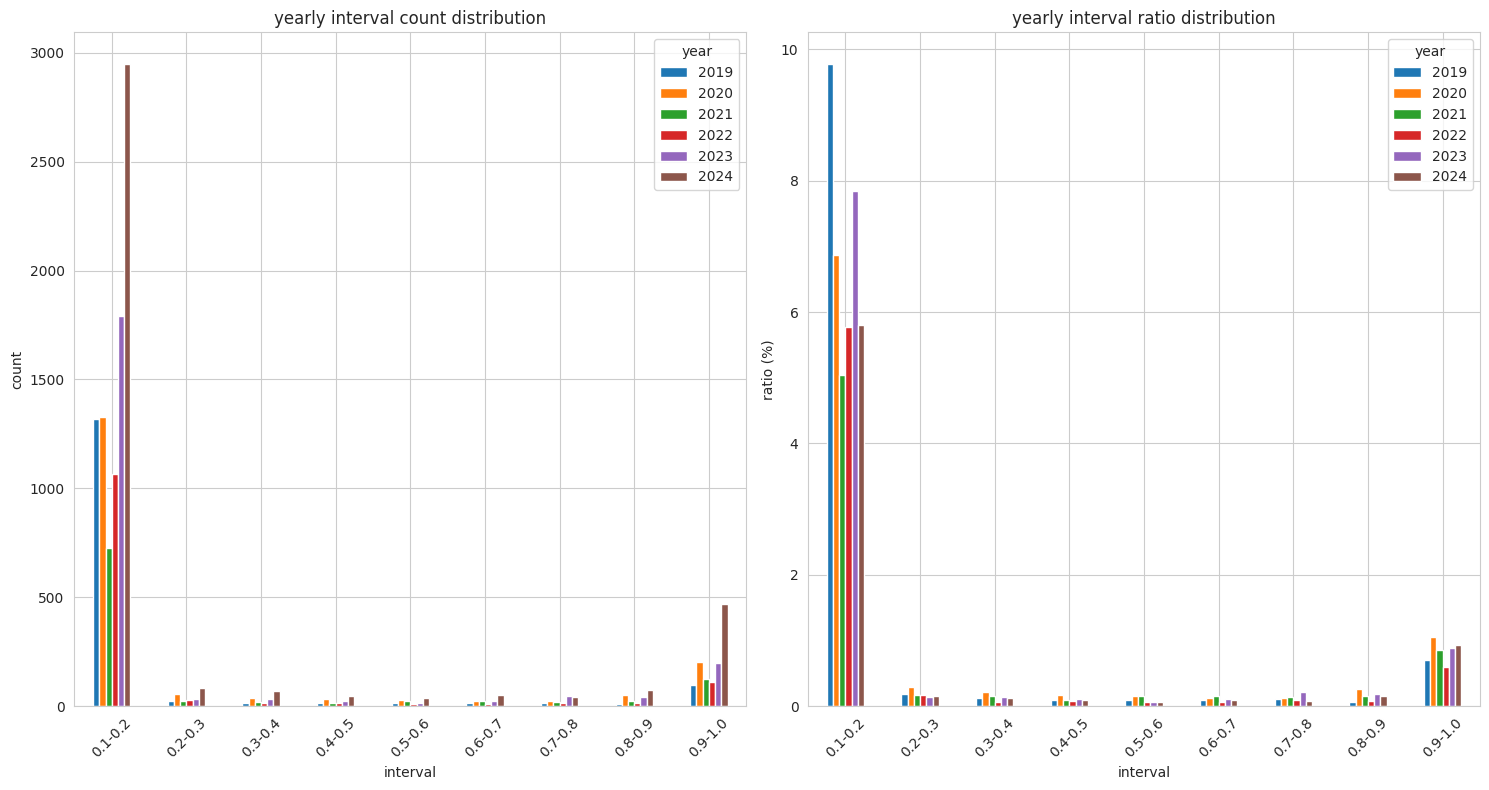

In [6]:
# score interval statistics analysis
# define score intervals
bins = [0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
labels = ['0.0-0.1', '0.1-0.2', '0.2-0.3', '0.3-0.4', '0.4-0.5', 
          '0.5-0.6', '0.6-0.7', '0.7-0.8', '0.8-0.9', '0.9-1.0']

# yearly interval statistics
interval_stats = []
for year in sorted(dfs.keys()):
    df = dfs[year]
    interval_counts = pd.cut(df[score_col], bins=bins, labels=labels, include_lowest=True).value_counts().sort_index()
    interval_percentages = (interval_counts / len(df) * 100).round(2)
    
    for interval, count, pct in zip(interval_counts.index, interval_counts.values, interval_percentages.values):
        interval_stats.append({
            'year': year,
            'interval': interval,
            'count': count,
            'ratio(%)': pct
        })

interval_df = pd.DataFrame(interval_stats)

# create pivot table
pivot_counts = interval_df.pivot(index='interval', columns='year', values='count').fillna(0)
pivot_percentages = interval_df.pivot(index='interval', columns='year', values='ratio(%)').fillna(0)

print("yearly interval statistics - count:")
print(pivot_counts.astype(int))
print("\nyearly interval statistics - ratio(%):")
print(pivot_percentages)

# visualize interval distribution
# only show 0.1-1.0 interval
pivot_counts = pivot_counts.loc[['0.1-0.2', '0.2-0.3', '0.3-0.4', '0.4-0.5', '0.5-0.6', '0.6-0.7', '0.7-0.8', '0.8-0.9', '0.9-1.0']]
pivot_percentages = pivot_percentages.loc[['0.1-0.2', '0.2-0.3', '0.3-0.4', '0.4-0.5', '0.5-0.6', '0.6-0.7', '0.7-0.8', '0.8-0.9', '0.9-1.0']]

plt.figure(figsize=(15, 8))

plt.subplot(1, 2, 1)
pivot_counts.plot(kind='bar', ax=plt.gca())
plt.title('yearly interval count distribution')
plt.xlabel('interval')
plt.ylabel('count')
plt.legend(title='year')
plt.xticks(rotation=45)

plt.subplot(1, 2, 2)
pivot_percentages.plot(kind='bar', ax=plt.gca())
plt.title('yearly interval ratio distribution')
plt.xlabel('interval')
plt.ylabel('ratio (%)')
plt.legend(title='year')
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()


In [7]:
# extreme value analysis
# yearly extreme high value statistics
extreme_stats = []
for year in sorted(dfs.keys()):
    df = dfs[year]
    
    # top 10 highest score
    top_20 = df.nlargest(20, score_col)[score_col].values
    
    # very high score statistics
    very_high = len(df[df[score_col] >= 0.9])
    
    extreme_stats.append({
        'year': year,
        'highest': df[score_col].max(),
        'very_high': very_high,
        'very_high_ratio(%)': round(very_high / len(df) * 100, 3),
        'top_20_mean': round(top_20.mean(), 4)
    })

extreme_df = pd.DataFrame(extreme_stats)
print("yearly extreme value analysis:")
print(extreme_df.to_string(index=False))


yearly extreme value analysis:
 year  highest  very_high  very_high_ratio(%)  top_20_mean
 2019 0.997483         96               0.710       0.9968
 2020 0.997677        205               1.061       0.9975
 2021 0.997630        123               0.853       0.9973
 2022 0.997609        110               0.596       0.9966
 2023 0.997668        200               0.876       0.9974
 2024 0.997692        471               0.929       0.9976


Annual change rate analysis:
   period  sample_count_change  sample_count_change_rate(%)  mean_change  mean_change_rate(%)  toxic_ratio_change  std_change
2019-2020               5815.0                        43.04       0.0022                 6.88                0.65      0.0205
2020-2021              -4912.0                       -25.42      -0.0063               -18.42               -0.29     -0.0132
2021-2022               4056.0                        28.14      -0.0043               -15.41               -0.56     -0.0183
2022-2023               4369.0                        23.65       0.0087                36.86                0.56      0.0219
2023-2024              27849.0                       121.93      -0.0038               -11.76               -0.11     -0.0031


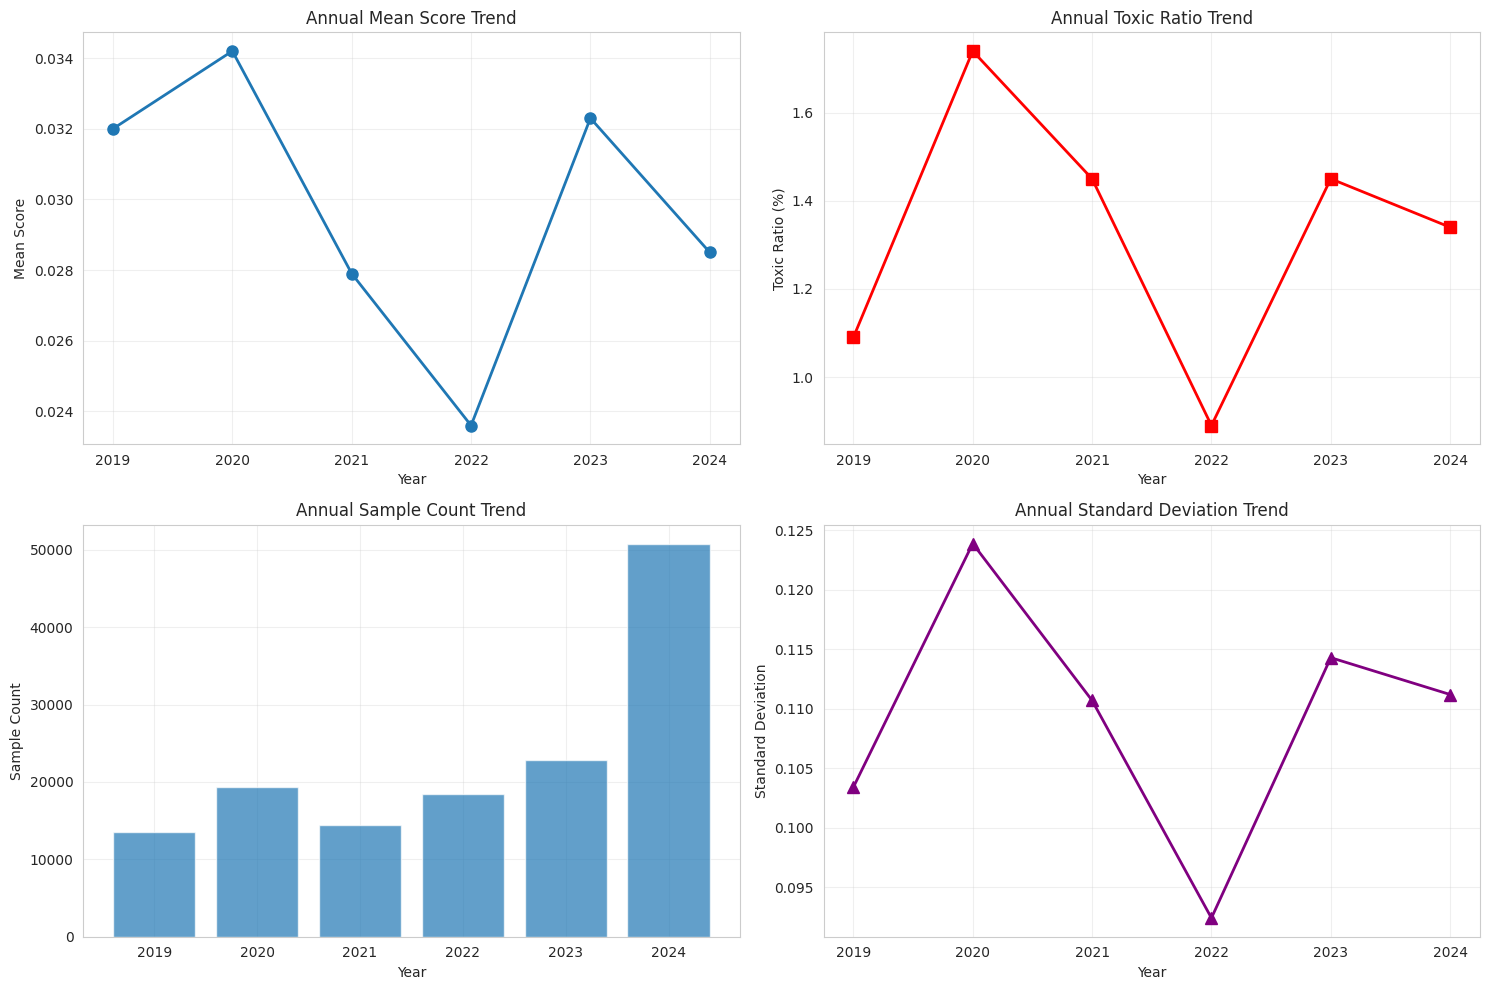

In [8]:
# Annual change rate analysis
change_analysis = []
# years = sorted(dfs.keys())

for i in range(1, len(years)):
    prev_year = years[i-1]
    curr_year = years[i]
    
    prev_stats = yearly_stats.loc[prev_year]
    curr_stats = yearly_stats.loc[curr_year]
    
    prev_toxic = toxic_df[toxic_df['year'] == prev_year].iloc[0]
    curr_toxic = toxic_df[toxic_df['year'] == curr_year].iloc[0]
    
    change_analysis.append({
        'period': f'{prev_year}-{curr_year}',
        'sample_count_change': curr_stats['count'] - prev_stats['count'],
        'sample_count_change_rate(%)': round((curr_stats['count'] - prev_stats['count']) / prev_stats['count'] * 100, 2),
        'mean_change': round(curr_stats['mean'] - prev_stats['mean'], 4),
        'mean_change_rate(%)': round((curr_stats['mean'] - prev_stats['mean']) / prev_stats['mean'] * 100, 2),
        'toxic_ratio_change': round(curr_toxic['toxic_ratio(%)'] - prev_toxic['toxic_ratio(%)'], 2),
        'std_change': round(curr_stats['std'] - prev_stats['std'], 4),
    })

change_df = pd.DataFrame(change_analysis)
print("Annual change rate analysis:")
print(change_df.to_string(index=False))

# Visualize change trends
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Mean score trend
axes[0,0].plot(yearly_stats.index, yearly_stats['mean'], marker='o', linewidth=2, markersize=8)
axes[0,0].set_title('Annual Mean Score Trend')
axes[0,0].set_xlabel('Year')
axes[0,0].set_ylabel('Mean Score')
axes[0,0].grid(True, alpha=0.3)
axes[0,0].set_xticks(years)

# Toxic ratio trend
axes[0,1].plot(toxic_df['year'], toxic_df['toxic_ratio(%)'], marker='s', linewidth=2, markersize=8, color='red')
axes[0,1].set_title('Annual Toxic Ratio Trend')
axes[0,1].set_xlabel('Year')
axes[0,1].set_ylabel('Toxic Ratio (%)')
axes[0,1].grid(True, alpha=0.3)
axes[0,1].set_xticks(years)

# Sample count trend
axes[1,0].bar(yearly_stats.index, yearly_stats['count'], alpha=0.7)
axes[1,0].set_title('Annual Sample Count Trend')
axes[1,0].set_xlabel('Year')
axes[1,0].set_ylabel('Sample Count')
axes[1,0].grid(True, alpha=0.3)
axes[1,0].set_xticks(years)

# Standard deviation trend
axes[1,1].plot(yearly_stats.index, yearly_stats['std'], marker='^', linewidth=2, markersize=8, color='purple')
axes[1,1].set_title('Annual Standard Deviation Trend')
axes[1,1].set_xlabel('Year')
axes[1,1].set_ylabel('Standard Deviation')
axes[1,1].grid(True, alpha=0.3)
axes[1,1].set_xticks(years)

plt.tight_layout()
plt.show()


In [9]:
# FIXED: Advanced statistical analysis
from scipy import stats

print("Advanced Statistical Analysis:")
print("=" * 40)

# Normality test
print("\nDistribution Feature Analysis:")
for year in sorted(dfs.keys()):
    data = dfs[year][score_col]
    
    # Shapiro-Wilk normality test (may not be suitable for large sample sizes)
    if len(data) <= 5000:  # Limit sample size
        stat, p_value = stats.shapiro(data.sample(min(len(data), 5000)))
        is_normal = "Yes" if p_value > 0.05 else "No"
        print(f"{year}: Skewness={stats.skew(data):.3f}, Kurtosis={stats.kurtosis(data):.3f}, Normal distribution={is_normal}")
    else:
        print(f"{year}: Skewness={stats.skew(data):.3f}, Kurtosis={stats.kurtosis(data):.3f}")

# Statistical significance test between years
print(f"\nSignificance Test Between Years:")
years_list = sorted(dfs.keys())
for i in range(len(years_list)):
    for j in range(i+1, len(years_list)):
        year1, year2 = years_list[i], years_list[j]
        data1 = dfs[year1][score_col]
        data2 = dfs[year2][score_col]
        
        # Mann-Whitney U test (non-parametric test)
        stat, p_value = stats.mannwhitneyu(data1, data2, alternative='two-sided')
        significance = "Significant" if p_value < 0.05 else "Not significant"
        print(f"{year1} vs {year2}: p-value={p_value:.6f}, Difference {significance}")

# Correlation analysis (if time series available)
print(f"\nTime Series Correlation:")
if len(years_list) >= 3:
    # Correlation between year and mean score
    years_numeric = list(yearly_stats.index)
    avg_scores = list(yearly_stats['mean'])
    correlation = stats.pearsonr(years_numeric, avg_scores)
    print(f"Year vs Mean Score correlation coefficient: {correlation[0]:.4f} (p-value: {correlation[1]:.4f})")
    
    # Correlation between year and toxic ratio
    toxic_ratios = [toxic_df[toxic_df['year'] == year]['toxic_ratio(%)'].iloc[0] for year in years_numeric]
    correlation_toxic = stats.pearsonr(years_numeric, toxic_ratios)
    print(f"Year vs Toxic Ratio correlation coefficient: {correlation_toxic[0]:.4f} (p-value: {correlation_toxic[1]:.4f})")

print("\n" + "=" * 40)


Advanced Statistical Analysis:

Distribution Feature Analysis:
2019: Skewness=6.774, Kurtosis=54.478
2020: Skewness=6.174, Kurtosis=41.077
2021: Skewness=7.013, Kurtosis=53.119
2022: Skewness=8.088, Kurtosis=74.734
2023: Skewness=6.515, Kurtosis=46.979
2024: Skewness=7.098, Kurtosis=54.648

Significance Test Between Years:
2019 vs 2020: p-value=0.000002, Difference Significant
2019 vs 2021: p-value=0.020210, Difference Significant
2019 vs 2022: p-value=0.000000, Difference Significant
2019 vs 2023: p-value=0.000000, Difference Significant
2019 vs 2024: p-value=0.949852, Difference Not significant
2020 vs 2021: p-value=0.016830, Difference Significant
2020 vs 2022: p-value=0.000000, Difference Significant
2020 vs 2023: p-value=0.001221, Difference Significant
2020 vs 2024: p-value=0.000000, Difference Significant
2021 vs 2022: p-value=0.000000, Difference Significant
2021 vs 2023: p-value=0.000000, Difference Significant
2021 vs 2024: p-value=0.003908, Difference Significant
2022 vs 202